# Training of the sentiment discriminator based on BERT and CNN

Discriminator 4: BERT with classification head. Based on https://huggingface.co/docs/transformers/tasks/sequence_classification

##Load libraries

In [ ]:
! pip install transformers datasets evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.0 MB/s eta 0:00:00


In [ ]:
pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 5.0 MB/s eta 0:00:00


In [ ]:
pip install accelerate -U

In [ ]:
import pandas as pd
from datasets import load_dataset,Dataset
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments
from transformers import DataCollatorWithPadding, Trainer,BertForSequenceClassification
import evaluate
import numpy as np
from transformers import pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import roc_curve,accuracy_score, recall_score, precision_score,f1_score
from sklearn.utils import shuffle

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Read data

In [ ]:
 path="/content/drive/MyDrive/Masterthesis/Data/data_processed/preprocessed50000_no_lower_with_punct_stop.tsv"
 data=pd.read_csv(path, sep='\t')
 data=data[["preprocessed_text","sentiment"]]
 data

,preprocessed_text,sentiment
0,Wenig Licht - Viel Schatten Wir sind nach eine...,0
1,"Alle Mitarbeiter sind sehr freundlich, sehr Au...",1
2,"Traumhafter Urlaub - vielen Dank Sehr schönes,...",1
3,Selten einen so witzigen Film gesehen. Bin ehe...,1
4,Das Hotel liegt nur 200m vom Meer entfernt und...,1
...,...,...
49995,Anspruchsvoller Urlaub? Laut Katalogbeschreibu...,1
49996,"Für eine Woche Badeurlaub alles da, Einkaufsst...",1
49997,"Die Poolanlage war relativ schön, das einzige ...",0
49998,ein großer speisesaal ein restaurant essen imm...,1


In [ ]:
data.rename(columns={"preprocessed_text":"text","sentiment":"label"}, inplace=True)
data

,text,label
0,Wenig Licht - Viel Schatten Wir sind nach eine...,0
1,"Alle Mitarbeiter sind sehr freundlich, sehr Au...",1
2,"Traumhafter Urlaub - vielen Dank Sehr schönes,...",1
3,Selten einen so witzigen Film gesehen. Bin ehe...,1
4,Das Hotel liegt nur 200m vom Meer entfernt und...,1
...,...,...
49995,Anspruchsvoller Urlaub? Laut Katalogbeschreibu...,1
49996,"Für eine Woche Badeurlaub alles da, Einkaufsst...",1
49997,"Die Poolanlage war relativ schön, das einzige ...",0
49998,ein großer speisesaal ein restaurant essen imm...,1


## Prepare data

First split data then oversample. Create Dataset

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(data["text"],data["label"],random_state=0,test_size=0.2, stratify=data["label"])
X_val,X_test, y_val, y_test = train_test_split(X_temp,y_temp,random_state=0,test_size=0.5, stratify=y_temp)


In [ ]:
oversample = RandomOverSampler(sampling_strategy='minority',random_state=0)
X_train_resampled, y_train_resampled = oversample.fit_resample(X_train.to_frame(), y_train.to_frame())

In [ ]:
df_test=pd.concat([X_test, y_test], axis=1)
df_val=pd.concat([X_val, y_val], axis=1)
df_train=pd.concat([X_train_resampled, y_train_resampled], axis=1)

In [ ]:
train = Dataset.from_pandas(df_train, preserve_index=False)
test = Dataset.from_pandas(df_test, preserve_index=False)
val = Dataset.from_pandas(df_val, preserve_index=False)

### Tokenize datasets

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-german-cased")

tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/456 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/240k [00:00<?, ?B/s]

In [ ]:
def tokenize_data(df):
    return tokenizer(df["text"], truncation=True)

In [ ]:
tokenized_train = train.map(tokenize_data, batched=True)
tokenized_val = val.map(tokenize_data, batched=True)
tokenized_test = test.map(tokenize_data, batched=True)


Map:   0%|          | 0/72466 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [ ]:
tokenized_train.set_format("pytorch")
tokenized_test.set_format("pytorch")
tokenized_val.set_format("pytorch")

##Prepare collator and metrics

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
metrics_eval = evaluate.load("glue", "mrpc")

In [ ]:
def metrics_calc(pred):
    prediction, label = pred
    prediction = np.argmax(prediction, axis=1)
    return metrics_eval.compute(predictions=prediction, references=label)

In [ ]:
id_to_label = {0: "NEGATIVE", 1: "POSITIVE"}
label_to_id = {"NEGATIVE": 0, "POSITIVE": 1}

## Train model

In [ ]:
model = BertForSequenceClassification.from_pretrained(
    "dbmdz/bert-base-german-cased", num_labels=2, id2label=id_to_label, label2id=label_to_id
)

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-german-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/Masterthesis/Models/finetuned_bert_sentiment1",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",

)

In [ ]:
#test)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=metrics_calc,)
#test))

In [ ]:
trainer.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.081100,0.261151,0.948000,0.971283


TrainOutput(global_step=4530, training_loss=0.17052594910131122, metrics={'train_runtime': 4510.8412, 'train_samples_per_second': 16.065, 'train_steps_per_second': 1.004, 'total_flos': 1.262748271322712e+16, 'train_loss': 0.17052594910131122, 'epoch': 1.0})

## Evaluate model

In [ ]:
trainer.evaluate(tokenized_test)

{'eval_loss': 0.2498570829629898,
 'eval_accuracy': 0.9516,
 'eval_f1': 0.9732832854934864,
 'eval_runtime': 101.3629,
 'eval_samples_per_second': 49.328,
 'eval_steps_per_second': 3.088,
 'epoch': 1.0}

In [ ]:
trainer.save_model("/content/drive/MyDrive/Masterthesis/Models/sentiment_discriminator_bert_finetuned")

In [ ]:
text = "Das war der beste Film was ich je gesehen habe. Ich will noch mal!"

In [ ]:
sentiment_pipe_kwargs = {"top_k": None, "function_to_apply": "none"}

In [ ]:
classifier = pipeline("sentiment-analysis", model="/content/drive/MyDrive/Masterthesis/Models/sentiment_discriminator_bert_finetuned",**sentiment_pipe_kwargs)
classifier(text)

[[{'label': 'POSITIVE', 'score': 3.395169258117676},
  {'label': 'NEGATIVE', 'score': -3.8205320835113525}]]

In [ ]:
text = "Das war der schlimmste Film was ich je gesehen habe. Nie mehr!"

In [ ]:
sentiment_pipe_kwargs = {"top_k": None, "function_to_apply": "none"}

In [ ]:
classifier = pipeline("sentiment-analysis", model="/content/drive/MyDrive/Masterthesis/Models/sentiment_discriminator_bert_finetuned",**sentiment_pipe_kwargs)
classifier(text)

[[{'label': 'NEGATIVE', 'score': 3.257197141647339},
  {'label': 'POSITIVE', 'score': -2.896399736404419}]]

In [ ]:
y_pred=classifier([" ".join(x.split()) for x in  test["text"] ],truncation=True)

In [ ]:
y_pred_labels=[x[0]["label"] for x in y_pred]

In [ ]:
mapped_list = [ label2id[label] for label in y_pred_labels]


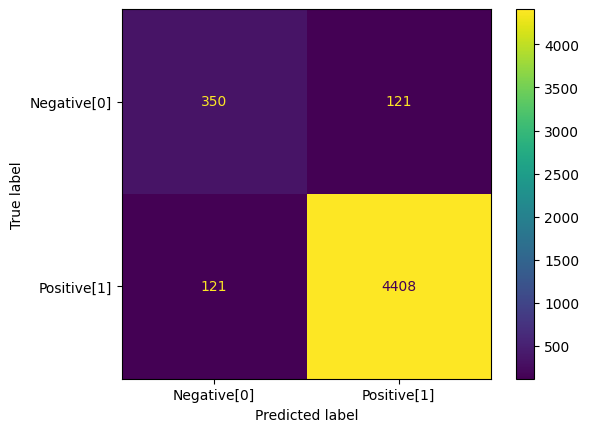

Accuracy: 0.9516
Recall: 0.9732832854934864
Precision: 0.9732832854934864
F1: 0.9732832854934864


In [ ]:

y_predicted = mapped_list
y_test=test["label"]

cm=confusion_matrix(y_test, y_predicted)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Negative[0]", "Positive[1]"])

cm_display.plot()
plt.show()

accuracy = accuracy_score(y_test, y_predicted)
print("Accuracy:", accuracy)

# Calculate recall
recall = recall_score(y_test, y_predicted)
print("Recall:", recall)

# Calculate precision
precision = precision_score(y_test, y_predicted)
print("Precision:", precision)

f1 = f1_score(y_test, y_predicted)
print("F1:", f1)
